## Importing necessary libraries

In [3]:
!pip install torchsummary

In [4]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

## Exploring the data

In [5]:
data_dir = "/content/drive/MyDrive/Oral Diseases Dataset"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = data_dir + "/test"
diseases = os.listdir(train_dir)

In [6]:
# printing the disease names
print(diseases)

['Calculus', 'Tooth Discoloration ', 'Gingivitis', 'Hypodontia', 'Mouth Ulcer', 'Dental Caries']


In [7]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 6


In [8]:
import os

oral_diseases_list = []
NumberOfDiseases = 0

# Get disease folder names
diseases = os.listdir(train_dir)

for disease in diseases:
    if os.path.isdir(os.path.join(train_dir, disease)):
        if disease not in oral_diseases_list:
            oral_diseases_list.append(disease)
            NumberOfDiseases += 1

print("Oral disease classes found:", oral_diseases_list)
print("Total number of oral disease classes:", NumberOfDiseases)


Oral disease classes found: ['Calculus', 'Tooth Discoloration ', 'Gingivitis', 'Hypodontia', 'Mouth Ulcer', 'Dental Caries']
Total number of oral disease classes: 6


In [9]:
# Unique oral diseases in the dataset
print(f"Unique Oral Diseases are: \n{oral_diseases_list}")


Unique Oral Diseases are: 
['Calculus', 'Tooth Discoloration ', 'Gingivitis', 'Hypodontia', 'Mouth Ulcer', 'Dental Caries']


In [10]:
# Number of unique oral diseases
print("Number of oral diseases: {}".format(len(oral_diseases_list)))


Number of oral diseases: 6


In [11]:
# Number of images for each oral disease
image_counts = {}

for disease in oral_diseases_list:
    disease_path = os.path.join(train_dir, disease)
    if os.path.isdir(disease_path):
        image_counts[disease] = len(os.listdir(disease_path))

# Converting the image_counts dictionary to a pandas DataFrame
img_per_class = pd.DataFrame(image_counts.values(), index=image_counts.keys(), columns=["No. of Images"])
img_per_class


,No. of Images
Calculus,972
Tooth Discoloration,1376
Gingivitis,1761
Hypodontia,939
Mouth Ulcer,1906
Dental Caries,1787


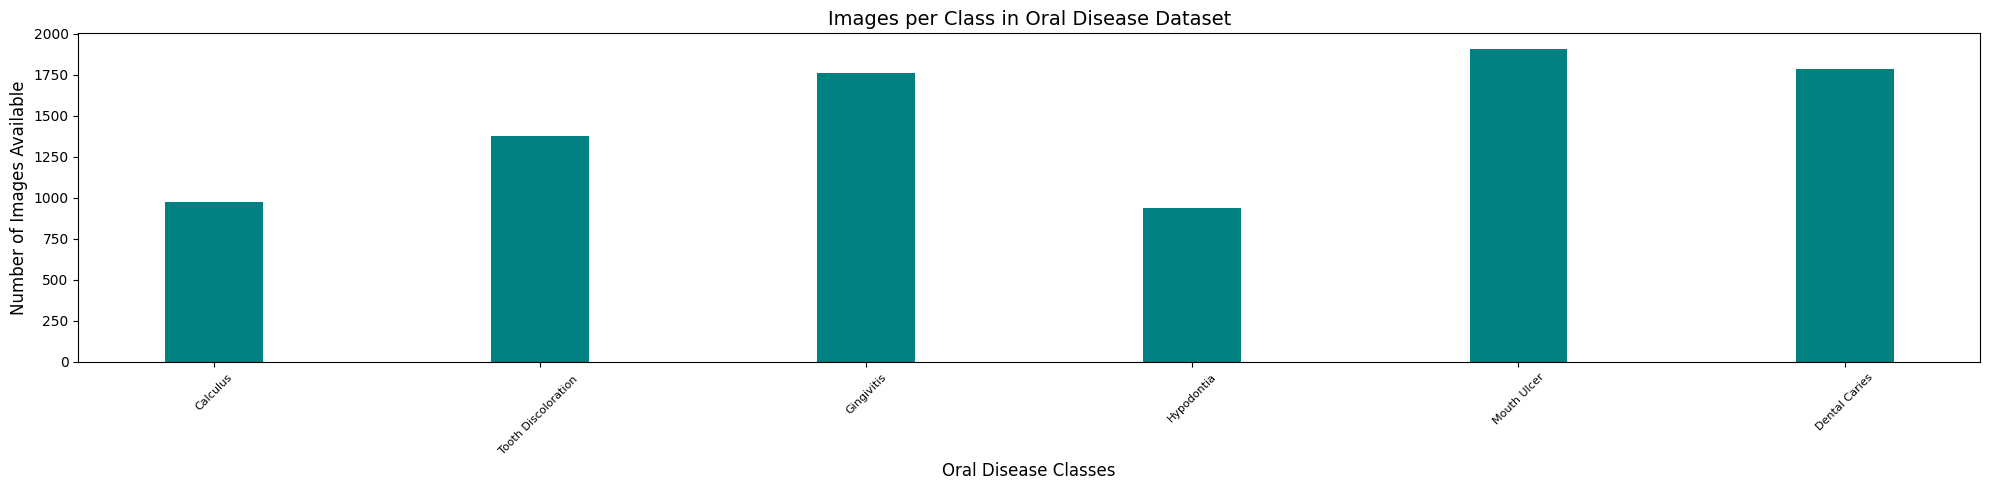

In [12]:
# Plotting number of images available for each oral disease
index = [n for n in range(len(image_counts))]
plt.figure(figsize=(20, 5))
plt.bar(index, list(image_counts.values()), width=0.3, color='teal')
plt.xlabel('Oral Disease Classes', fontsize=12)
plt.ylabel('Number of Images Available', fontsize=12)
plt.xticks(index, list(image_counts.keys()), fontsize=8, rotation=45)
plt.title('Images per Class in Oral Disease Dataset', fontsize=14)
plt.tight_layout()
plt.show()


#### Images available for training

In [13]:
# Total number of training images
n_train = 0
for value in image_counts.values():
    n_train += value

print(f"There are {n_train} images for training in the Oral Diseases Dataset.")


There are 8741 images for training in the Oral Diseases Dataset.


#  Data Preparation for training

In [14]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())


In [15]:
img, label = train[0]
print(img.shape, label)


torch.Size([3, 408, 612]) 0


In [16]:
# total number of classes in train set
len(train.classes)


6

In [17]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))


## 🖼️ Some Images from training dataset 🖼️

Label :Gingivitis(2)


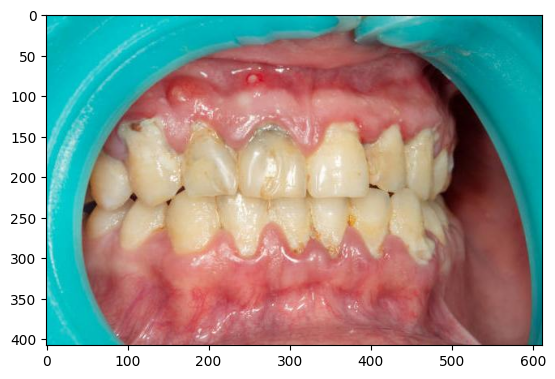

In [18]:
show_image(*train[3000])

Label :Dental Caries(1)


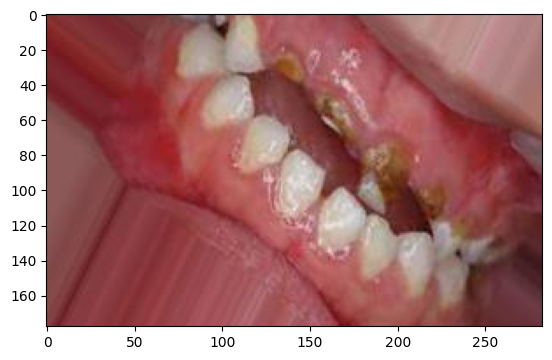

In [19]:
show_image(*train[1000])

In [20]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)


In [21]:
# Define consistent image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize all images to 224x224
    transforms.ToTensor()
])


In [22]:
# Load the datasets with transforms applied
train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform)


In [23]:
# Set batch size
batch_size = 32

In [24]:
# Create the DataLoaders
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size=batch_size, num_workers=2, pin_memory=True)


In [25]:
# Helper function to show a batch of training images
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        plt.show()
        break


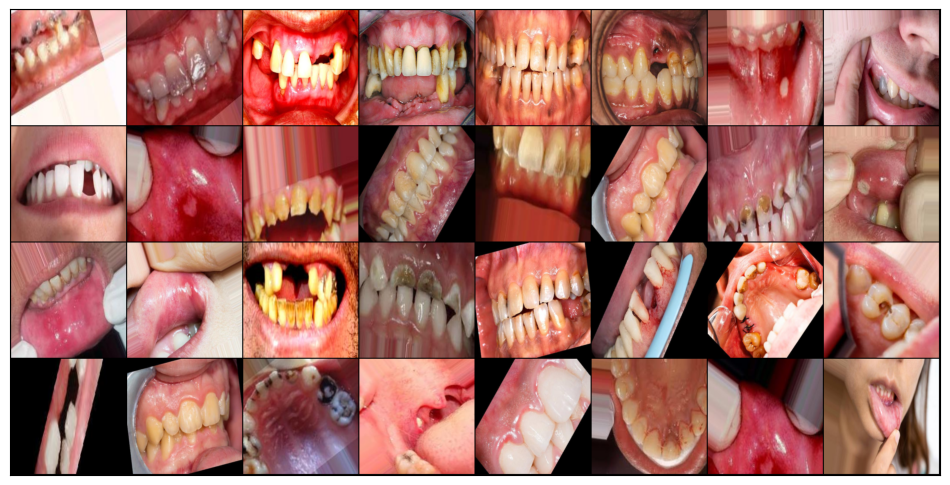

In [26]:
# Show the first batch from the training DataLoader
show_batch(train_dl)


# 🏗️ Modelling 🏗️

In [27]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# 👷 Building the model architecture 👷

#### Residual Block code implementation

In [30]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [31]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


## 👷 Defining the final architecture of our model 👷

In [36]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [37]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [38]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

# 🏋️ Training the model 🏋️

In [39]:
# Move tensor(s) to chosen device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Wrap a dataloader to move data to device
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model
model = to_device(model, device)

# Wrap dataloaders
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [41]:
def forward(self, xb):
    out = self.conv1(xb)
    print(f"After conv1: {out.shape}")
    out = self.conv2(out)
    print(f"After conv2: {out.shape}")
    out = self.res1(out) + out
    print(f"After res1: {out.shape}")
    out = self.conv3(out)
    print(f"After conv3: {out.shape}")
    out = self.conv4(out)
    print(f"After conv4: {out.shape}")
    out = self.res2(out) + out
    print(f"After res2: {out.shape}")
    out = self.classifier(out)
    print(f"After classifier: {out.shape}")
    return out


In [42]:
import torch.nn as nn

def ConvBlock(in_channels, out_channels, pool=False, pool_size=2, pool_stride=2):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=pool_size, stride=pool_stride))
    return nn.Sequential(*layers)


In [43]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        # First conv block (no down‐sampling)
        self.conv1 = ConvBlock(in_channels, 64)

        # Second block: down‐sample by 2×2 pooling
        self.conv2 = ConvBlock(64, 128, pool=True, pool_size=2, pool_stride=2)
        self.res1  = nn.Sequential(
            ConvBlock(128, 128),
            ConvBlock(128, 128)
        )

        # Third block: further down‐sample
        self.conv3 = ConvBlock(128, 256, pool=True, pool_size=2, pool_stride=2)
        self.conv4 = ConvBlock(256, 512, pool=True, pool_size=2, pool_stride=2)
        self.res2  = nn.Sequential(
            ConvBlock(512, 512),
            ConvBlock(512, 512)
        )

        # Global pooling + classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier      = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, num_diseases)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.global_avg_pool(out)
        return self.classifier(out)


In [44]:
# after these definitions run:
model = ResNet9(3, len(train.classes))
print(model)


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [45]:
import torch
import torch.nn as nn

# --- Evaluation Helper ---
@torch.no_grad()
def evaluate(model, val_loader, device):
    model.eval()
    outputs = []
    for batch in val_loader:
        batch = to_device(batch, device)
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

# --- LR Helper ---
def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

# --- One‐Cycle Training Loop ---
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, device,
                 weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    # Clear CUDA cache only if available (harmless otherwise)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Move model to the chosen device once
    model = to_device(model, device)

    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)
    )

    history = []
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            batch = to_device(batch, device)

            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Optional gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & step LR scheduler
            lrs.append(get_lr(optimizer))
            sched.step()

        # --- Validation Phase ---
        result = evaluate(model, val_loader, device)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs

        # Print epoch summary & store history
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [46]:
# Pick device (CUDA on Colab, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Wrap your DataLoaders
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Hyperparameters
epochs       = 50
max_lr       = 1e-3
grad_clip    = 0.1
weight_decay = 1e-4
opt_func     = torch.optim.Adam

# Train!
history = fit_OneCycle(
    epochs, max_lr, model,
    train_dl, valid_dl,
    device, weight_decay, grad_clip, opt_func
)


Epoch [0], last_lr: 0.00005, train_loss: 1.0741, val_loss: 1.0148, val_acc: 0.6089
Epoch [1], last_lr: 0.00008, train_loss: 0.8527, val_loss: 1.1615, val_acc: 0.5405
Epoch [2], last_lr: 0.00013, train_loss: 0.7839, val_loss: 0.9415, val_acc: 0.6326
Epoch [3], last_lr: 0.00020, train_loss: 0.7106, val_loss: 0.8810, val_acc: 0.6793
Epoch [4], last_lr: 0.00028, train_loss: 0.6919, val_loss: 0.6711, val_acc: 0.7366
Epoch [5], last_lr: 0.00037, train_loss: 0.6540, val_loss: 0.7569, val_acc: 0.7342
Epoch [6], last_lr: 0.00047, train_loss: 0.6174, val_loss: 1.7078, val_acc: 0.4784
Epoch [7], last_lr: 0.00057, train_loss: 0.5966, val_loss: 1.0756, val_acc: 0.6260
Epoch [8], last_lr: 0.00067, train_loss: 0.5546, val_loss: 2.5042, val_acc: 0.4262
Epoch [9], last_lr: 0.00076, train_loss: 0.5422, val_loss: 1.3878, val_acc: 0.5934
Epoch [10], last_lr: 0.00084, train_loss: 0.5266, val_loss: 1.6160, val_acc: 0.5354
Epoch [11], last_lr: 0.00091, train_loss: 0.4994, val_loss: 0.8505, val_acc: 0.7109
Ep

# 📈 Plotting 📈

#### Helper functions for plotting

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracies(history):
    accuracies = [x['val_accuracy'].cpu().item() if torch.is_tensor(x['val_accuracy']) else x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss').cpu().item() if torch.is_tensor(x.get('train_loss')) else x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().item() if torch.is_tensor(x['val_loss']) else x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([np.array(x.get('lrs', [])) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.show()


## Validation Accuracy

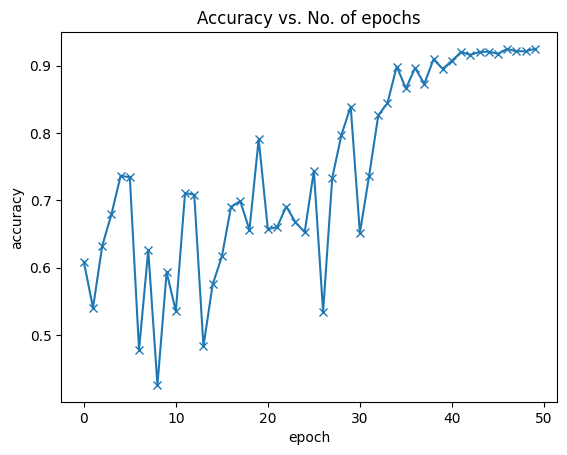

In [48]:
plot_accuracies(history)

## Validation loss

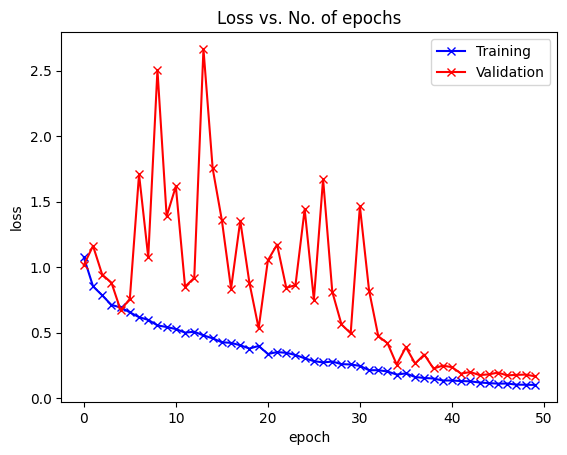

In [49]:
plot_losses(history)

## Learning Rate overtime

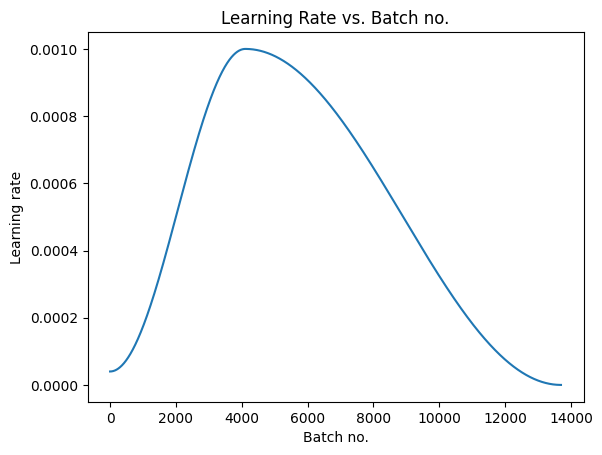

In [50]:
plot_lrs(history)

# 🧪 Testing model on test data 🧪

**We only have 36 images in test data, so let's check the model on all images**

In [51]:
from torch.utils.data import Dataset
from PIL import Image
import os

class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_filenames[idx]  # returning image + filename

# Define transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Use custom dataset loader
test_dir = "/content/drive/MyDrive/Oral Diseases Dataset/test"
test_dataset = TestImageDataset(test_dir, transform=test_transform)


In [52]:
import os

test_dir = "/content/drive/MyDrive/Oral Diseases Dataset/test"
test_images = sorted(os.listdir(test_dir))

# Optional: filter only image files
test_images = [img for img in test_images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

test_images


['(313).JPG',
 '(314).JPG',
 '(315).JPG',
 '(316).JPG',
 '(317).JPG',
 '(318).JPG',
 '(571).jpg',
 '(572).jpg',
 '(573).jpg',
 '(574).jpg',
 '(575).jpg',
 '(576).jpg',
 '(718).jpg',
 '(719).jpg',
 '(720).jpg',
 '(721).jpg',
 '(722).jpg',
 '(723).jpg',
 'Mouth_Ulcer_0_4071.jpeg',
 'Mouth_Ulcer_0_4074.jpeg',
 'Mouth_Ulcer_0_4082.jpeg',
 'Mouth_Ulcer_0_4083.jpeg',
 'Mouth_Ulcer_0_4085.jpeg',
 'Mouth_Ulcer_0_4093.jpeg',
 'Tooth_Discoloration_0_9853.jpeg',
 'Tooth_Discoloration_0_9856.jpeg',
 'Tooth_Discoloration_0_9859.jpeg',
 'Tooth_Discoloration_0_9863.jpeg',
 'Tooth_Discoloration_0_9869.jpeg',
 'Tooth_Discoloration_0_9871.jpeg',
 'caries_0_8742.jpeg',
 'caries_0_8743.jpeg',
 'caries_0_8747.jpeg',
 'caries_0_8753.jpeg',
 'caries_0_8754.jpeg',
 'caries_0_8758.jpeg']

Label: (313).JPG , Predicted: Hypodontia


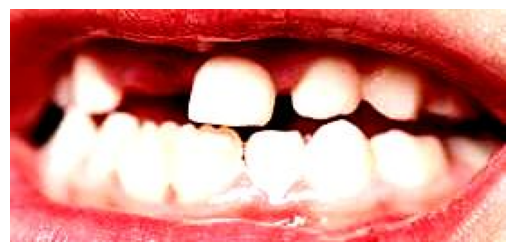

In [53]:
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Path to a test image (use actual image name from test_images list)
img_path = os.path.join(test_dir, test_images[0])

# Define the same transform used during training/validation
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load image
img = Image.open(img_path).convert('RGB')
img_tensor = test_transform(img)

# Prediction function
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)  # Add batch dimension and move to device
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return class_names[preds[0].item()]  # Use your class label list

# Make sure you define the class names (same as train.classes if used with ImageFolder)
class_names = ['Calculus', 'Dental Caries', 'Gingivitis', 'Hypodontia', 'Mouth Ulcer', 'Tooth Discoloration']

# Predict and plot
plt.imshow(img)
plt.axis('off')
print('Label:', test_images[0], ', Predicted:', predict_image(img_tensor, model))


In [54]:
# getting all predictions (actual label vs predicted)
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

# Path to test images
test_dir = "/content/drive/MyDrive/Oral Diseases Dataset/test"
test_images = sorted([f for f in os.listdir(test_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Define the same transform used during training
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Class names (adjust if you have different ones)
class_names = ['Calculus', 'Dental Caries', 'Gingivitis', 'Hypodontia', 'Mouth Ulcer', 'Tooth Discoloration']

# Predict function
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return class_names[preds[0].item()]

# Loop through all test images
for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, img_name)
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(img)
    predicted_class = predict_image(img_tensor, model)

    print(f'Image: {img_name}, Predicted: {predicted_class}')


Image: (571).jpg, Predicted: Calculus
Image: (572).jpg, Predicted: Calculus
Image: (573).jpg, Predicted: Calculus
Image: (574).jpg, Predicted: Gingivitis
Image: (575).jpg, Predicted: Calculus
Image: (576).jpg, Predicted: Calculus
Image: (718).jpg, Predicted: Gingivitis
Image: (719).jpg, Predicted: Gingivitis
Image: (720).jpg, Predicted: Gingivitis
Image: (721).jpg, Predicted: Gingivitis
Image: (722).jpg, Predicted: Gingivitis
Image: (723).jpg, Predicted: Gingivitis
Image: Mouth_Ulcer_0_4071.jpeg, Predicted: Mouth Ulcer
Image: Mouth_Ulcer_0_4074.jpeg, Predicted: Mouth Ulcer
Image: Mouth_Ulcer_0_4082.jpeg, Predicted: Mouth Ulcer
Image: Mouth_Ulcer_0_4083.jpeg, Predicted: Mouth Ulcer
Image: Mouth_Ulcer_0_4085.jpeg, Predicted: Mouth Ulcer
Image: Mouth_Ulcer_0_4093.jpeg, Predicted: Mouth Ulcer
Image: Tooth_Discoloration_0_9853.jpeg, Predicted: Tooth Discoloration
Image: Tooth_Discoloration_0_9856.jpeg, Predicted: Tooth Discoloration
Image: Tooth_Discoloration_0_9859.jpeg, Predicted: Tooth D

# Saving the model

1. **Save/Load `state_dict`**

In [55]:
# saving to the drive working directory
PATH = '/content/drive/MyDrive/Oral Diseases Dataset/new_oral_disease_model.pth'
torch.save(model.state_dict(), PATH)

2. **Save/Load Entire Model**

In [56]:
# saving the entire model to working directory
PATH = '/content/drive/MyDrive/Oral Diseases Dataset/new_oral_disease_model_complete.pth'
torch.save(model, PATH)

3. **Save/Load Entire Model with Pickle Extension**

In [57]:
# saving the entire model to working directory
PATH = '/content/drive/MyDrive/Oral Diseases Dataset/new_oral_pick_model_complete.pkl'
torch.save(model, PATH)

4. **Save/Load Entire Model with HDFS Extension**

In [58]:
# saving the entire model to working directory
PATH = '/content/drive/MyDrive/Oral Diseases Dataset/new_oral_hdf_model_complete.h5'
torch.save(model, PATH)